<a href="https://colab.research.google.com/github/Ira-Sharma/Video_Captioning_TensorFlow_MSVD/blob/main/Video_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all the libraries required

In [73]:
import glob
import shutil
import cv2
import json
import random
import config
import joblib
import time
import os, sys
import datetime
import keras
import imageio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle, functools, operator
from tqdm.notebook import tqdm
from nltk import FreqDist
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model

from PIL import Image, ImageSequence


Feature Extraction

In [ ]:
config.test_path="/content/drive/MyDrive/YouTubeClips "#containing all the videos in the avi format in the avi folder

In [ ]:
# Conversion of videos into image frames
def video_to_frames(video):
    path = os.path.join(config.test_path, 'temporary_images')
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    video_path = os.path.join(config.test_path, 'video', video)
    count = 0
    image_list = []
    # Path to video file
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret is False:
            break
        cv2.imwrite(os.path.join(config.test_path, 'temporary_images', 'frame%d.jpg' % count), frame)
        image_list.append(os.path.join(config.test_path, 'temporary_images', 'frame%d.jpg' % count))
        count += 1

    cap.release()
    cv2.destroyAllWindows()
    return image_list

In [ ]:
# Loading the VGG16 model
def model_cnn_load():
    model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    out = model.layers[-2].output
    model_final = Model(inputs=model.input, outputs=out)
    return model_final

In [ ]:
# Resizing the images
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    return img

In [ ]:
# Feature extraction of the videos using the VGG16 model
def extract_features(video, model):
    """
    video: The video whose frames are to be extracted to convert into a numpy array
    model: the pretrained vgg16 model
    return: numpy array of size 4096x80
    """
    video_id = video.split(".")[0]
    print(video_id)
    print(f'Processing video {video}')

    image_list = video_to_frames(video)
    samples = np.round(np.linspace(
        0, len(image_list) - 1, 80))
    image_list = [image_list[int(sample)] for sample in samples]
    images = np.zeros((len(image_list), 224, 224, 3))
    for i in range(len(image_list)):
        img = load_image(image_list[i])
        images[i] = img
    images = np.array(images)
    fc_feats = model.predict(images, batch_size=128)
    img_feats = np.array(fc_feats)
    # cleanup of the image frames folder
    shutil.rmtree(os.path.join(config.test_path, 'temporary_images'))
    return img_feats

In [ ]:
# Feature Extraction of the all the videos 
def extract_feats_pretrained_cnn():
    """
    saves the numpy features from all the videos
    """
    model = model_cnn_load()
    print('Model loaded')

    if not os.path.isdir(os.path.join(config.test_path, 'feat')):
      os.mkdir(os.path.join(config.test_path, 'feat'))

    video_list = glob.glob(os.path.join(config.test_path,'*.avi'))
    for video in video_list:
      outfile = os.path.join(config.test_path,'feat', video.split(".")[0] + '.npy')
      img_feats = extract_features(video, model)
      np.save(outfile, img_feats)

In [ ]:
extract_feats_pretrained_cnn()

553476096/553467096 [==============================] - 10s 0us/step
Model loaded
/content/drive/MyDrive/YouTubeClips /avi/jbzaMtPYtl8_48_58
Processing video /content/drive/MyDrive/YouTubeClips /avi/jbzaMtPYtl8_48_58.avi
/content/drive/MyDrive/YouTubeClips /avi/jCplbayVbtw_10_20
Processing video /content/drive/MyDrive/YouTubeClips /avi/jCplbayVbtw_10_20.avi
/content/drive/MyDrive/YouTubeClips /avi/FGjtmhI-Rmk_30_37
Processing video /content/drive/MyDrive/YouTubeClips /avi/FGjtmhI-Rmk_30_37.avi
/content/drive/MyDrive/YouTubeClips /avi/bLqmf8x7rLI_2_8
Processing video /content/drive/MyDrive/YouTubeClips /avi/bLqmf8x7rLI_2_8.avi
/content/drive/MyDrive/YouTubeClips /avi/0sUL0KCIc48_15_25
Processing video /content/drive/MyDrive/YouTubeClips /avi/0sUL0KCIc48_15_25.avi
/content/drive/MyDrive/YouTubeClips /avi/EpMuCrbxE8A_107_115
Processing video /content/drive/MyDrive/YouTubeClips /avi/EpMuCrbxE8A_107_115.avi
/content/drive/MyDrive/YouTubeClips /avi/lexLAjh8fPA_27_31
Processing video /content/

In [ ]:
# All the numpy features shifted to a feat folder
sourcepath='/content/drive/MyDrive/YouTubeClips /avi'
sourcefiles = os.listdir(sourcepath)
destinationpath = '/content/drive/MyDrive/YouTubeClips /feat'
for file in sourcefiles:
  if file.endswith('.npy'):
    shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))


Getting the captions data

In [ ]:
# Using only the English captions from the video corpus (caption data in .csv format)
text_data=pd.read_csv('/content/drive/MyDrive/video_corpus.csv')
text_data = text_data[text_data["Language"] == "English"]
text_data

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...
...,...,...,...,...,...,...,...,...
122597,m7x8uIdg2XU,67,73,749155,unverified,61,English,Milk being poured to a bowl of pasta
122598,m7x8uIdg2XU,67,73,303815,unverified,73,English,the girls are mixing the milk
122599,m7x8uIdg2XU,67,73,309959,unverified,19,English,The lady added a cream sauce to the pasta.
122600,m7x8uIdg2XU,67,73,130040,unverified,27,English,women are cooking her kichen


In [ ]:
text_data.to_csv(r'video_corpus_captions.txt', header=None, index=None, sep=',', mode='a') # storing all the English captions in a .txt file

In [ ]:
with open('video_corpus_captions.txt', 'r') as f: 
    captions_doc = f.read()

Mapping

In [ ]:
# create mapping of video to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    video_id,start,end, caption = tokens[0],tokens[1],tokens[2],tokens[7:]
    # remove extension from video ID and adding the start and end
    video_id = video_id.split('.')[0]+'_'+start+'_'+end
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if video_id not in mapping:
        mapping[video_id] = []
    # store the caption
    mapping[video_id].append(caption)

  0%|          | 0/85497 [00:00<?, ?it/s]

In [ ]:
mapping

In [ ]:
# Checking the extra videoIDs and cleaning the mapping/captions data
x=[]
for i in list(mapping.keys()):
  if i+'.avi' not in os.listdir('/content/drive/MyDrive/YouTubeClips /avi'):
    x.append(i)
print(x)

['KLgPTlBLHmo_18_21', 'D-K3ThvAqfo_126_130', 'eyBmG9ZZnLM_215_219', 'ph-72iVQQnU_38_48', 'uRo_vJ-zy-U_35_40', 'iju4KO-3KnY_2_12', 'fvXXLP6A4p4_109_119', 'TJXEKN7nwUc_11_49', '1dmVuwO1RZk_214_220', 'dvhJGidrrKE_254_260', 'dvhJGidrrKE_98_101', 'eQcUmH0VE90_9_15', 'QsKIlhn6if8_270_276', 'VoKJr0EOzCU_136_142', 'tZzJ9dDnncY_37_41', 'MUkKFFdpm4E_121_135', 'KWK7szRdbrE_80_90', 'I2eWXGaoWko_20_24', 'tgm4dRGBeJ0_289_294', 'BiVJel79edY_154_168', 'QsKIlhn6if8_39_49', '6ERey_f0Qmw_20_25', 'Ofr7FWbnPqU_1_11', 'eyBmG9ZZnLM_103_108', 'l_AVz90c4jQ_22_43', '3Da8WdYYoOk_5_20', 'PxygpGLKEps_410_420', 'Sude_yGIbJI_18_67', 'z3v8BMNdDvo_1_13', 'hGmsx2P1qHw_95_100', '9eJPVpoOtOs_115_130', 'Lz-2QTNp5O8_6_16', 'BiVJel79edY_223_240', 'n9bFBSSJ4Fk_32_39', 'yqvwrNm4eZ0_3_13', 'lqeojs7S0qI_181_186', 't1Oqko6IKBE_0_11', '61OSscPtQWQ_1_6', 'TO0X4DQZKqk_35_41', '8SxALJoNNFI_10_21', 'WlGESqqv0jg_77_82', 'IiH6yl3j4gI_20_30', 'dF1n2Sa2eCE_6_14', 'D-K3ThvAqfo_151_158', 'fnEvy64GuIE_137_146', '7mKqoUiXIeY_7_15', 'ctUQPVFf

In [ ]:
for z in x:
  mapping.pop(z)# Removing the captions of extra videoIDs

In [ ]:
len(mapping)

1969

In [ ]:
with open('mapping.json', 'w') as f:
    json.dump(mapping, f)# making a json file of the mapping dict

In [ ]:
# Splitting the mapping keys into train and test IDs
video_ids = list(mapping.keys())
train_data = video_ids[:int(len(video_ids) * 0.8)]
test_data = video_ids[int(len(video_ids) * 0.8):]

In [ ]:
len(train_data)

1575

In [ ]:
# Folders containing all the videos in .avi format and the numpy features in .npy format respectively
avi = "/content/drive/MyDrive/YouTubeClips /avi"
feat= "/content/drive/MyDrive/YouTubeClips /feat"

In [ ]:
# Making the training videos folder
train_vid=[]
for i in train_data:
  shutil.move(os.path.join(avi,i+'.avi'), os.path.join('/content/drive/MyDrive/YouTubeClips /train_avi',i+'.avi'))
  train_vid.append(i+'.avi')

In [ ]:
# Making the training features folder
train_feat=[]
for i in train_data:
  shutil.move(os.path.join(feat,i+'.npy'), os.path.join('/content/drive/MyDrive/YouTubeClips /train_feat',i+'.npy'))
  train_feat.append(i+'.npy')

In [ ]:
# Making a training captions json file
train_label={}
for i in train_data:
  if i not in train_label:
        train_label[i] = []
  train_label[i].append(mapping[i])
print(train_label)

In [ ]:
with open('train_label.json', 'w') as f:
    json.dump(train_label, f)

In [ ]:
# Making the testing videos folder
test_vid=[]
for i in test_data:
  shutil.move(os.path.join(avi,i+'.avi'), os.path.join('/content/drive/MyDrive/YouTubeClips /test_avi',i+'.avi'))
  test_vid.append(i+'.avi')

In [ ]:
# Making the testing features folder
test_feat=[]
for i in test_data:
  shutil.move(os.path.join(feat,i+'.npy'), os.path.join('/content/drive/MyDrive/YouTubeClips /test_feat',i+'.npy'))
  test_feat.append(i+'.npy')

In [ ]:
# Making a testing captions json file
test_label={}
for i in test_data:
  if i not in test_label:
        test_label[i] = []
  test_label[i].append(mapping[i])
print(test_label)

In [ ]:
import json
with open('test_label.json', 'w') as f:
    json.dump(test_label, f)

Preprocessing the Training captions data

In [4]:
train_path='/content/drive/MyDrive/YouTubeClips '
TRAIN_LABEL_PATH = os.path.join(train_path, 'train_label.json')
# mentioning the train test split
train_split = 0.8
# loading the json file for training
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)


In [5]:
y_data

{'mv89psg6zh4_33_46': [['A bird in a sink keeps getting under the running water from a faucet ',
   'A bird is bathing in a sink ',
   'A bird is splashing around under a running faucet ',
   'A bird is bathing in a sink ',
   'A bird is standing in a sink drinking water that is pouring out of the facet ',
   'A faucet is running while a bird stands in the sink below ',
   'A bird is playing in a sink with running water ',
   'A bird is playing in tap water ',
   'A bird is bathing in the sink ',
   'A bird is taking a bath ',
   'A bird is taking a shower in a sink ',
   'A bird is showering in the sink ',
   'The bird is taking a bath under the faucet ',
   'A parakeet is taking a shower in a sink ',
   'A bird gets washed ',
   'A bird is having a bath in the kitchen sink ',
   'A bird is bathing in a sink under running water ',
   'the bird is drinking water',
   'A bird walks under a running tap in a sink ',
   'a parrot is playing inside the wash basin ',
   'a bird in a sink n p

In [6]:
# train_list contains all the captions with their video ID
train_list = []

for key,captions in list(y_data.items()):
  for i in range(len(captions)):
    for j in range(len(list(captions[i]))):
        caption = list(captions[i])[j]
        caption = caption.lower()
        # delete digits, special chars, etc., 
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        caption = "<bos> " + caption + " <eos>"
        # we are only using sentences whose length lie between 6 and 10
        if len(caption.split())>10 or len(caption.split())<6:
          continue
        else:
          train_list.append([caption, key])
print(len(train_list))
random.shuffle(train_list)

48386


In [7]:
train_list

[['<bos> a boy is talking  <eos>', 'GPT4vUwlrXY_1_10'],
 ['<bos> a girl is reading news paper <eos>', 'eVSQiPbepXg_44_49'],
 ['<bos> a baby is falling asleep  <eos>', '4Hhdr1IPOGs_1_10'],
 ['<bos> a girl is playing guitar  <eos>', 'Rf0TUCA3XNs_3_16'],
 ['<bos> a cartoon character is doing circus  <eos>', 'VZ6H73nH7xs_27_33'],
 ['<bos> a man is dancing on stage  <eos>', 'Gh4Beb8StFM_29_50'],
 ['<bos> a child is playing guitar  <eos>', 'tYQ7O6V0Fvk_20_55'],
 ['<bos> a man bounces his head  <eos>', '4QdX5Q3qQsQ_38_44'],
 ['<bos> a person sprinkles shredded cheese on a tortilla  <eos>',
  'Je3V7U5Ctj4_569_576'],
 ['<bos> the people are singing and swaying  <eos>', 'lmCrIZeob4w_23_26'],
 ['<bos> a man is riding on a horse  <eos>', 'PiyoeFC31kE_9_27'],
 ['<bos> a person is stirring a souse  <eos>', 'UXs3eq68ZjE_235_240'],
 ['<bos> a guy is playing a guitar  <eos>', '30PpKtVT8Z4_35_50'],
 ['<bos> a man gets hit by an egg  <eos>', 'KqKUXRHHkCc_101_105'],
 ['<bos> the little white dog barked an

In [8]:
# vocab_list contains all the vocabulary from training data
vocab_list = []
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]
for train in training_list:
    vocab_list.append(train[0])
len(vocab_list)

38708

In [13]:
# Tokenizing the words
tokenizer = Tokenizer(num_words=2226)# Taking the words occuring five or more number of times only
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))
x_data = {}
TRAIN_FEATURE_DIR = '/content/drive/MyDrive/YouTubeClips /train_feat'
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(TRAIN_FEATURE_DIR):
    f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename))
    x_data[filename[:-4]] = f
print(len(training_list))
print(len(validation_list))
len(x_data)

6358
38708
9678


1575

In [14]:
# creating corpus
corpus = ""
for el in vocab_list:
    corpus += " "+el

In [15]:
total_words = corpus.split()
vocabulary = set(total_words)
print("The size of vocabulary is {}".format(len(vocabulary)))

The size of vocabulary is 6492


In [16]:
vocabulary

{'paying',
 'swiping',
 'whisk',
 'fog',
 'carries',
 'father',
 'boarding',
 'fork',
 'cinder',
 'seasoning',
 'sweeper',
 'ankles',
 'announcer',
 'money',
 'ones',
 'seems',
 'menacing',
 'zebra-horse',
 'ammadi',
 'musical',
 'rear',
 'elk',
 'gentleman',
 'laughed',
 'convertible',
 'ski-is',
 'irish',
 'racing',
 'fluffy',
 'possesses',
 'nails',
 'boll',
 'rehearsing',
 'hamster',
 'baby',
 'glove',
 'soaked',
 'mousse',
 'dumbbells',
 'gym',
 'breaded',
 'shapes',
 'paws',
 'dipped',
 'omelette',
 'dominoes',
 'feet',
 'rabbi',
 'thief',
 'when',
 'past',
 'enclosed',
 'cellphone',
 'used',
 "doggy's",
 'stretching',
 'caret',
 'porcupine',
 'heavy',
 'american',
 'litter',
 'curving',
 'reporters',
 'karaoke',
 'raiding',
 'avocado',
 'fail',
 'teenage',
 'carrying',
 'detailed',
 'channels',
 'rains',
 'hairs',
 'spit',
 'stunk',
 'motorcycles',
 'rushes',
 'automated',
 'hugging',
 'eyebrow',
 'enjoying',
 'crowd',
 'killed',
 'showed',
 'cucumbers',
 'chocolate',
 'rubber',

In [17]:
# creating frequency distribution of words
freq_dist = FreqDist(total_words)
sorted_freq=freq_dist.most_common(len(vocabulary))# in ascending order
sorted_df=pd.DataFrame(sorted_freq, columns=["Word","Frequency"])# creating a dataframe of the frequency distribution of words in ascending order
sorted_df

,Word,Frequency
0,a,39016
1,<bos>,38708
2,<eos>,38708
3,is,22316
4,the,12398
...,...,...
6487,teen-ager,1
6488,weighted,1
6489,bro,1
6490,noah's,1


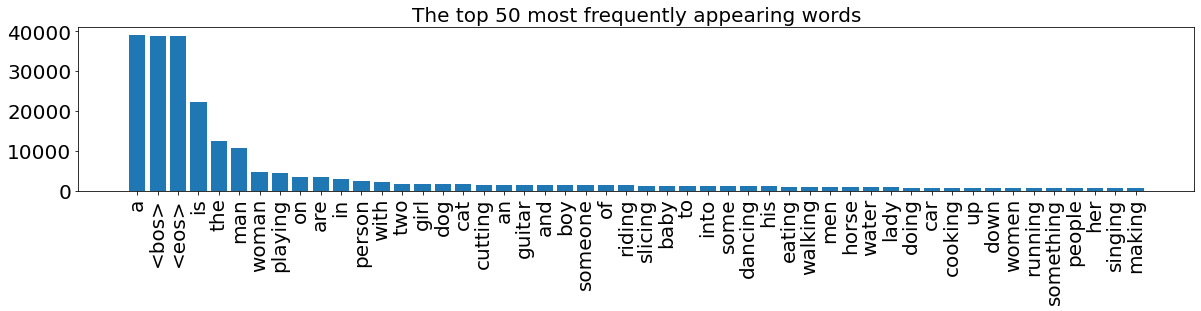

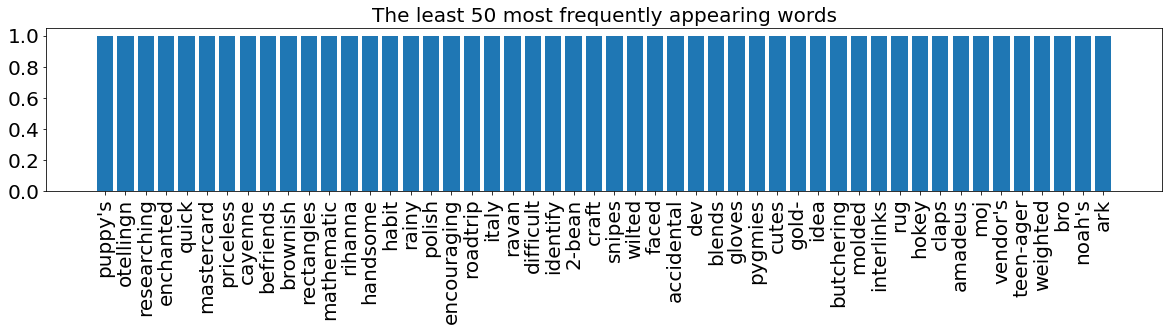

In [18]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["Frequency"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["Word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(sorted_df.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(sorted_df.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Model creation

In [19]:
# Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=150, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=2226,training_list=train_list, batch_size=32, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        encoder_input_data.append(x_data[videoId[idx]])
        y = to_categorical(train_sequences[idx], num_decoder_tokens)
        decoder_input_data.append(y[:-1])
        decoder_target_data.append(y[1:])
        if n == batch_size:
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          yield ([encoder_input, decoder_input], decoder_target)

In [20]:
# writing the train and validation generator
train = load_datatest(train_path='training_data',batch_size=320, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(train_path='training_data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=150)

In [21]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=80
num_encoder_tokens=4096
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=2226
batch_size=320
epochs=150

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 4096)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 2226)]   0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    9439232     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

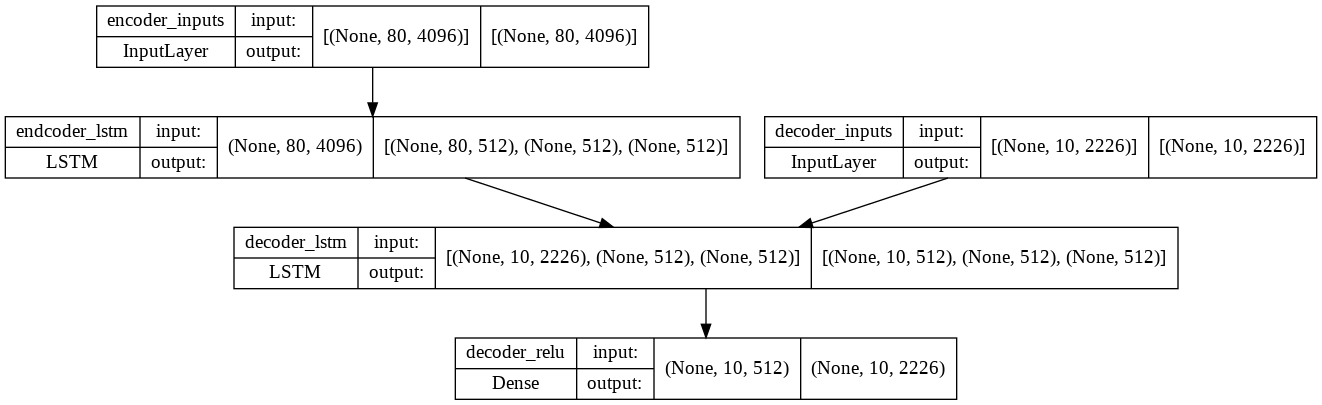

In [22]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Loading the tensorboard to visualise results
%load_ext tensorboard
%tensorboard --logdir logs

Training the Model

In [24]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = tf.keras.optimizers.Adam(lr = 0.0007)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=epochs, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


Epoch 1/150
120/120 [==============================] - 106s 799ms/step - loss: 3.4740 - accuracy: 0.4076 - val_loss: 2.9458 - val_accuracy: 0.4604 - lr: 7.0000e-04
Epoch 2/150
120/120 [==============================] - 85s 707ms/step - loss: 2.7705 - accuracy: 0.4983 - val_loss: 2.5213 - val_accuracy: 0.5417 - lr: 7.0000e-04
Epoch 3/150
120/120 [==============================] - 95s 790ms/step - loss: 2.3579 - accuracy: 0.5667 - val_loss: 2.1823 - val_accuracy: 0.5915 - lr: 7.0000e-04
Epoch 4/150
120/120 [==============================] - 86s 718ms/step - loss: 2.0524 - accuracy: 0.6098 - val_loss: 1.9388 - val_accuracy: 0.6251 - lr: 7.0000e-04
Epoch 5/150
120/120 [==============================] - 95s 792ms/step - loss: 1.8357 - accuracy: 0.6397 - val_loss: 1.7763 - val_accuracy: 0.6501 - lr: 7.0000e-04
Epoch 6/150
120/120 [==============================] - 85s 712ms/step - loss: 1.6791 - accuracy: 0.6612 - val_loss: 1.6519 - val_accuracy: 0.6672 - lr: 7.0000e-04
Epoch 7/150
120/120 [

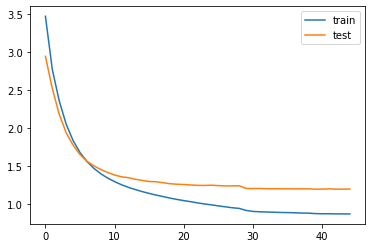

In [25]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')
plt.show()

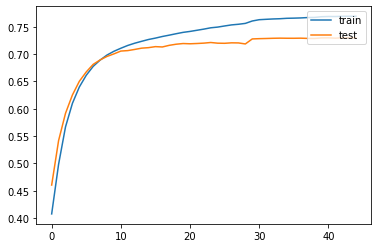

In [26]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy.png')
plt.show()

In [27]:
# Saving the model
save_model(model, "model_vidcap.h5")

In [ ]:
# load model
model = load_model('/content/model_vidcap.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 80, 4096)]       0         
                                                                 
 endcoder_lstm (LSTM)        [(None, 80, 512),         9439232   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 9,439,232
Trainable params: 9,439,232
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 10, 2226)]   0           []                               

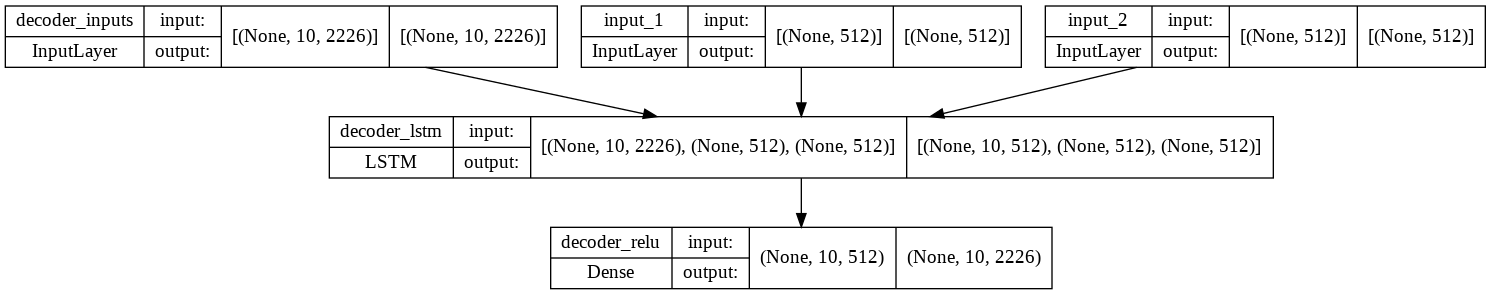

In [28]:
save_model_path = 'model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

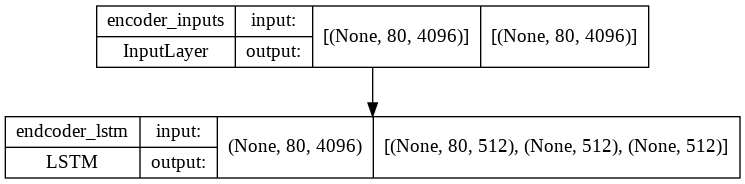

In [29]:
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)

Inference Models

In [57]:
test_path = "/content/drive/MyDrive/YouTubeClips "
batch_size = 320
learning_rate = 0.0007
epochs = 150
latent_dim = 512
num_encoder_tokens = 4096
num_decoder_tokens = 2226
time_steps_encoder = 80
max_probability = -1
save_model_path = 'model_final'
validation_split = 0.15
max_length = 10
search_type = 'greedy'

In [31]:
# models
encoder_model = None
decoder_model = None
inf_encoder_model = None
inf_decoder_model = None
tokenizer = None

In [32]:
# load tokenizer
with open(os.path.join(save_model_path, 'tokenizer' + str(num_decoder_tokens)), 'rb') as file:
  tokenizer = joblib.load(file)

# inference encoder model
inf_encoder_model = load_model(os.path.join(save_model_path, 'encoder_model.h5'))

# inference decoder model
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
inf_decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
inf_decoder_model.load_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))


Caption Generation using Greedy Search Technique

In [48]:
def greedy_search(f):
        """
                :param f: the loaded numpy array after creating videos to frames and extracting features
                :return: the final sentence which has been predicted greedily
                """
        inv_map = index_to_word()
        states_value = inf_encoder_model.predict(f.reshape(-1, 80, 4096))
        target_seq = np.zeros((1, 1, 2226))
        sentence = ''
        target_seq[0, 0, tokenizer.word_index['bos']] = 1
        for i in range(15):
            output_tokens, h, c = inf_decoder_model.predict([target_seq] + states_value)
            states_value = [h, c]
            output_tokens = output_tokens.reshape(num_decoder_tokens)
            y_hat = np.argmax(output_tokens)
            if y_hat == 0:
                continue
            if inv_map[y_hat] is None:
                break
            else:
                sentence = sentence + inv_map[y_hat] + ' '
                target_seq = np.zeros((1, 1, 2226))
                target_seq[0, 0, y_hat] = 1
        return ' '.join(sentence.split()[:-1])

In [49]:
def decode_sequence2bs( input_seq):
        states_value = inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, tokenizer.word_index['bos']] = 1
        beam_search(target_seq, states_value, [], [], 0)
        return decode_seq

In [50]:
def beam_search( target_seq, states_value, prob, path, lens):
        """
                :param target_seq: the array that is fed into the model to predict the next word
                :param states_value: previous state that is fed into the lstm cell
                :param prob: probability of predicting a word
                :param path: list of words from each sentence
                :param lens: number of words
                :return: final sentence
                """
        global decode_seq
        node = 2
        output_tokens, h, c = inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape(num_decoder_tokens)
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(tokenizer.word_index.keys())[
                    list(tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 12
            if sampled_char != 'eos' and lens <= MAX_LEN:
                p = output_tokens[sampled_token_index[i]]
                if sampled_char == '':
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                beam_search(target_seq, states_value, prob_new, path_new, lens + 1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if p > max_probability:
                    decode_seq = path
                    max_probability = p

In [51]:
def decoded_sentence_tuning( decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        uni_gram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in uni_gram:
                uni_gram[c] += 1
            else:
                uni_gram[c] = 1
            if last_string == c and idx2 > 0:
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str


In [52]:
def index_to_word():
  # inverts word tokenizer
  index_to_word = {value: key for key, value in tokenizer.word_index.items()}
  return index_to_word

Testing the Model 

In [35]:
X_test=[]
TEST_FEATURE_DIR = '/content/drive/MyDrive/YouTubeClips /test_feat'
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(TEST_FEATURE_DIR):
    g = np.load(os.path.join(TEST_FEATURE_DIR, filename))
    X_test.append(g)
X_test=np.array(X_test)

In [37]:
X_test_filename=[]
test_path='/content/drive/MyDrive/YouTubeClips '
TEST_LABEL_PATH = os.path.join(test_path, 'test_label.json')
# loading the json file for training
with open(TEST_LABEL_PATH) as data_file:    
    test_data = json.load(data_file)
X_test_filename= list(test_data.keys())
print(X_test_filename)

['Qp-k0H93iJE_35_39', 'aJoDt4DMkFU_118_124', 'IEQyCcageGg_99_126', 'Wv3u2q3oGeU_35_45', 'CGllPWAwmUo_1_15', '0lh_UWF9ZP4_183_190', 'FAD8CbQuvco_35_45', '4wT7zM8XgXQ_5_11', 'pfQPRXcihkI_127_138', 'PAN5IVvMlVc_17_23', 'GWQTAe64m-0_160_166', 'shPymuahrsc_5_12', '0lh_UWF9ZP4_21_26', 'Li3umATsU0E_1_5', 'SzEbtbNSg04_28_48', 'bK-i_FAcpoY_86_92', 'Vn0Xv0fb1z4_18_30', 'Z3XarHZ3HpY_10_17', 'VU4qLrk5axA_40_58', '-Ms9tsWmhyU_80_95', '6t0BpjwYKco_59_69', 'dZBIdRGKRhM_13_32', 'tZmDWltBziM_70_80', 'r0rmrbTb7fU_98_109', 'kRNHJSc4AXE_220_228', 'ID2xXlUENG0_19_24', 'XEOH3t5AYY0_22_29', 'p9g06ktIkJg_4_11', 'm1NR0uNNs5Y_73_78', 'iLr7ZHAq1ro_7_11', '9Q0JfdP36kI_56_64', '7uF-2adCsI0_60_67', 'zkTn5Ef1Oig_70_75', '-rkErLY0rRc_63_67', 'sv5YlZspb30_10_20', 'J_evFB7RIKA_104_120', 'AKVBK-0veE8_5_12', '_O9kWD8nuRU_70_76', '6gQu8PWhFoQ_37_41', 'IhwPQL9dFYc_171_175', '0lh_UWF9ZP4_62_69', 'b24_bb57PPk_631_637', 'TPD5wO_LEPU_2_6', '8MVo7fje_oE_108_113', '6vC6AT27RUc_29_46', 'HzYtvOYOEoU_21_32', '4D1o4FC8YbA_29_39', 'I

In [58]:
def test():
        """
            writes the captions of all the testing videos in a text file
        """
        # generate inference test outputs
        with open(os.path.join(test_path, 'test_%s.txt' % search_type), 'w') as file:
            for idx, x in enumerate(X_test):
                file.write(X_test_filename[idx] + ',')
                if search_type is 'greedy':
                    start = time.time()
                    decoded_sentence = greedy_search(x.reshape(-1, 80, 4096))
                    file.write(decoded_sentence + ',{:.2f}'.format(time.time()-start))
                else:
                    start = time.time()
                    decoded_sentence = decode_sequence2bs(x.reshape(-1, 80, 4096))
                    decode_str = decoded_sentence_tuning(decoded_sentence)
                    for d in decode_str:
                        file.write(d + ' ')
                    file.write(',{:.2f}'.format(time.time() - start))
                file.write('\n')

                # re-init max prob
                max_probability = -1

In [59]:
test()

In [60]:
#Getting the test data
TEST_LABEL_PATH = '/content/drive/MyDrive/YouTubeClips /test_label.json'
# loading the json file 
with open(TEST_LABEL_PATH) as data_file:    
    test_data = json.load(data_file)

In [61]:
#Preprocessing the actual captions 
test_list = {}
for key,captions in list(test_data.items()):
  for i in range(len(captions)):
    for j in range(len(list(captions[i]))):
        caption = list(captions[i])[j]
        caption = caption.lower()
        # delete digits, special chars, etc., 
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # we are only using sentences whose length lie between 6 and 10
        if len(caption.split())>10 or len(caption.split())<6:
          continue
        elif key not in test_list:
            test_list[key] = []
        # store the caption
        test_list[key].append(caption)

In [62]:
data=pd.read_csv('/content/drive/MyDrive/YouTubeClips /test_greedy.txt', header = None)# Opening the Predicted captions .txt file
print(data)

                       0                                           1     2
0      Qp-k0H93iJE_35_39                a man is playing with a ball  0.72
1    aJoDt4DMkFU_118_124               a man is doing two two people  0.74
2     IEQyCcageGg_99_126                   a man is peeling a potato  0.74
3      Wv3u2q3oGeU_35_45                         a man playing piano  0.75
4       CGllPWAwmUo_1_15  a woman is putting ingredients into a bowl  0.75
..                   ...                                         ...   ...
389  0lh_UWF9ZP4_103_110                 a woman is frying some food  0.75
390     x68Djm_Q0GA_0_10                   a man is cutting a potato  0.74
391     X6uJyuD_Zso_3_17                            a boy is running  0.77
392    R2DvpPTfl-E_20_25                a woman is slicing some meat  0.75
393    m7x8uIdg2XU_67_73                            a man is running  0.76

[394 rows x 3 columns]


In [90]:
# Calculating the BLEU score on the actual and predicted captions
actual, predicted, bleu, gcaptions = list(), list(), list(), list()

for key in tqdm(test_list):
    # get actual caption
    captions = test_list[key]
    # predict the caption for image
    y_pred = y_pred = data.loc[data[0]==key][1].values[0]
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    score=sentence_bleu(actual_captions, y_pred, weights=(1.0, 0, 0, 0))
    bleu.append(score)
    if score>0.8 and score<0.9:
        gcaptions.append(key)
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/394 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BLEU-1: 0.546524
BLEU-2: 0.346926


Text(0.5, 1.0, 'Videos and their corresponding Bleu Score between 0 to 1')

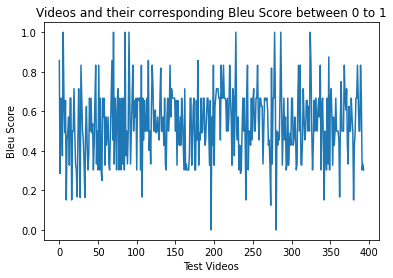

In [160]:
x=[]
for i in range(0, len(test_list)):
  x.append(i)
plt.plot(x,bleu)
plt.xlabel('Test Videos')
plt.ylabel('Bleu Score')
plt.title('Videos and their corresponding Bleu Score between 0 to 1')

Generating the Captions

In [134]:
def generate_caption(video_name):
    # load the video
    # video_name = ".avi"
    video_id = video_name.split('.')[0]
    vid_path = os.path.join('/content/drive/MyDrive/YouTubeClips /test_avi', video_name)
    captions = test_list[video_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = data.loc[data[0]==video_id][1].values[0]
    print('--------------------Predicted--------------------')
    print(y_pred)


In [135]:
generate_caption("0lh_UWF9ZP4_183_190.avi")

---------------------Actual---------------------
a woman is slicing a meat into pieces.
a woman is slicing a fish fillet with a knife.
a woman is cutting tuna into slices.
a woman is slicing tuna to make sushi.
a woman is slicing some tuna.
a woman is cutting raw fish.
the lady sliced the raw meat.
the woman is slicing raw fish.
a woman is slicing a tuna steak into strips.
a woman cuts up some meat.
the lady cut the raw fish.
a woman is cutting a piece of fish.
a woman is slicing a piece of fish.
a lady is slicing a meat
a woman with a poodle slices salmon.
a lady is cutting the fish.
the lady sliced the raw fish.
the woman is slicing raw fish.
the women is cutting the bread pieces
--------------------Predicted--------------------
a woman is slicing a piece of fish


In [136]:
generate_caption("-_hbPLsZvvo_43_55.avi")

---------------------Actual---------------------
an oriental lady is cutting a carrot into thin pieces.
a woman is shown slicing a carrot into small pieces.
a woman is chopping a carrot.
a woman is cutting vegetables into quarter moons.
a woman is slicing a carrot.
a woman cuts a carrot with a knife.
a woman is cutting a carrot.
the woman is cutting a carrot.
a woman is slicing a carrot.
a woman is cutting a carrot.
a lady is chopping up a carrot.
a delicious food is on the table.
a woman is chopping up a carrot.
a woman is cutting a carrot.
a woman is showing how to cut the carrot
how to make bento and japanese boxed lunch
there is a healthy prepared japanese boxed lunch
a japanese lady preparing lunch from potato and carrot.
"a short clip aboout japanese boxed lunch ""bento""."
a view of japanese boxed lunch.
a woman cutting a carrot using knife.
a woman is cutting a carrot.
a woman is cutting carrot into small pieces.
a woman is quartering a carrot.
a woman is sectioning and cutting

In [137]:
generate_caption("tn1d5DmdMqY_15_28.avi")

---------------------Actual---------------------
a man is playing a guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing the guitar.
a man is playing the guitar.
a man is playing the guitar.
a man is playing the guitar.
a man plays an acoustic guitar.
a man seated is playing a guitar.
the man is playing the guitar.
a man is playing a guitar.
a man is playing a guitar.
a man is playing the guitar.
a man is playing the guitar.
a man is playing the guitar.
a man is playing a guitar
a man is playing a guitar.
a man is playing the guitar.
the man is playing the guitar.
a man is playing a guitar.
a man is playing acoustic guitar.
--------------------Predicted--------------------
a man is playing a guitar


In [155]:
generate_caption("Wv3u2q3oGeU_35_45.avi")

---------------------Actual---------------------
a man is playing an electric keyboard.
a man is playing a piano.
a man is playing a piano.
someone is playing a piano keyboard.
a man is playing a keyboard.
a man is playing music on a keyboard.
a man is playing a piano keyboard.
a man is playing the keyboard.
a man is playing the keyboard.
the man is playing the keyboards.
a man is playing an electric keyboard.
a man is playing the keyboards.
the person is playing the key broad
a person is playing a keyboard.
a man is playing a song on the piano.
a man is playing the piano.
a man is playing a keyboard.
a close-up of playing the keyboard.
a man is playing the keyboard.
the man played the electonic keyboard.
the man is playing the keyboards.
--------------------Predicted--------------------
a man playing piano


In [139]:
generate_caption("0hyZ__3YhZc_289_295.avi")

---------------------Actual---------------------
someone pours chopped vegetables into a kettle.
a person puts mixed vegetables into a pot.
a man puts vegetables into a pot.
someone is putting vegetables into a pot.
a man is adding something to a cooking bowl.
someone is adding vegetables to a pot.
someone is putting vegetables into a pot.
someone is pouring ingrediants into a pot.
a person is adding chopped vegetables to a pot.
the man is dropping vegetables into the pot.
a man dumps some stir fry into a pot.
the man added cut vegetables to the pot and oil.
a person is cooking the chill vegetarian
someone is pouring vegetable in a pot.
a man making vagetarian chilli in the kitchen
a person is mixing vegetables in the water
vegetables being added to a vessel for cooking
the man added the vegetables to the pot.
the man dropped vegetables in the pot.
someone empties a bowl of chopped vegetables into a pot.
a person is pouring some vegetable.
the person is cooking the curry
the person is 

In [140]:
generate_caption("Qp-k0H93iJE_35_39.avi")

---------------------Actual---------------------
a man strikes a ball with a bat.
a cricket player hits the ball.
the cricket player hit the ball.
a man bats a cricket ball.
the cricket player hit the ball.
a baseball game is being played.
a cricketer made a funny moment in a match.
a man is hitting a ball with a bat.
a cricket player misses the ball.
a man is throwing a cricket ball.
--------------------Predicted--------------------
a man is playing with a ball


In [141]:
generate_caption("Ffv7fhL1EDY_177_184.avi")

---------------------Actual---------------------
a soccer player dribbles past his opponents.
a man is kicking a soccer ball.
men are playing soccer on a field.
a man moves a soccer ball down the field.
a man is kicking a soccer ball down the field.
a fat football player eludes leaner players.
a man dribbles a soccer ball down the field.
the man dribbled the soccer ball down the field.
a foot ball match is playing
two teams are playing football match.
a soccer player passing the ball
a set of old people playing football
the man tricked the other soccer player.
a group of men are playing soccer.
a man is running and kicking a ball.
--------------------Predicted--------------------
a man is playing with a ball


In [142]:
generate_caption("bDoCQEwghZU_201_211.avi")

---------------------Actual---------------------
a man is spinning in a chair.
two boys are talking on the phone.
a boy is talking on the phone.
two men are speaking on the phone.
two guys are talking on the phone.
a man is talking on a phone.
a man is making a telephone call.
a man is having a conversation on the phone.
a man talks on the telephone.
a guy is speaking on the telephone.
a guy is talking on the phone.
the man is talking on the phone.
a man talks on his cell phone.
a man is talking in a phone
two men are talking on the phone.
a man talking with someone on phone
a boy giving a presentation in front of many people.
a man is talking through phone
a man is rolling in his chair.
a boy is talking with his friend.
two men are taking to each other on the phone.
a man spins in a chair while on the phone.
a man is talking in phone.
a man replies to a phone call.
two men are talking to each other on the phone.
the man is talking on the phone.
two men are talking on the phone to each

In [143]:
generate_caption("hJFBXHtxKIc_310_315.avi")

---------------------Actual---------------------
a man dips a fork into spaghetti in a bowl.
a man is eating a food.
a man demonstrates a food dish.
a man is twirling spaghetti onto a fork.
a man is twirling spaghetti onto a fork.
the man tried some sauce and pasta.
a man is spinning spaghetti onto a fork.
the man tasted the noodle and sauce.
a man eats a bowl of spaghetti.
a man is tasting the food
a man is taking the food by the fork.
a person is cooking spaghetti sauce
the person is eating the noodles
--------------------Predicted--------------------
a man is eating spaghetti


In [157]:
generate_caption("GWQTAe64m-0_160_166.avi")

---------------------Actual---------------------
a young woman is dancing in a cage.
a woman is dancing in a cage.
a woman is dancing in a cage.
a young woman is dancing in a cage.
a woman is dancing in a cage.
a girl is dancing in a cage.
a girl is dancing in a cage.
the go-go dancer danced in the cage.
the woman is dancing in a cage.
a woman in a cage dances.
the lady danced in a cage.
a woman is dancing in a cage.
a woman is dancing in a cage.
a woman is dancing in a cage.
a woman from the  70's dancing in a cage.
a woman is applying make up on face.
a woman is dancing in a cage.
the go-go dancer danced in the cage.
the woman is dancing in a cage.
the girl is doing the dancing
--------------------Predicted--------------------
a girl is singing


Generating GIFs

In [ ]:
# Function for generating the GIFs
def convertVideoToGifFile(inputFile, outputFile=None):
    in_path=os.path.join('/content/drive/MyDrive/Youtube/test_avi',inputFile)
    if not outputFile:
        outputFile = os.path.splitext(inputFile)[0] + ".gif"
		
    print("Converting {0} to {1}".format(in_path, outputFile))

    reader = imageio.get_reader(in_path)
    fps = reader.get_meta_data()['fps']

    writer = imageio.get_writer(outputFile, fps=fps)
	
    for i,im in enumerate(reader):
        writer.append_data(im)

    writer.close()
	
    print("\r\nConversion done.")

In [145]:
convertVideoToGifFile("-_hbPLsZvvo_43_55.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/-_hbPLsZvvo_43_55.avi to -_hbPLsZvvo_43_55.gif

Conversion done.


In [146]:
convertVideoToGifFile("tn1d5DmdMqY_15_28.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/tn1d5DmdMqY_15_28.avi to tn1d5DmdMqY_15_28.gif

Conversion done.


In [156]:
convertVideoToGifFile("Wv3u2q3oGeU_35_45.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/Wv3u2q3oGeU_35_45.avi to Wv3u2q3oGeU_35_45.gif

Conversion done.


In [149]:
convertVideoToGifFile("0hyZ__3YhZc_289_295.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/0hyZ__3YhZc_289_295.avi to 0hyZ__3YhZc_289_295.gif

Conversion done.


In [150]:
convertVideoToGifFile("Qp-k0H93iJE_35_39.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/Qp-k0H93iJE_35_39.avi to Qp-k0H93iJE_35_39.gif

Conversion done.


In [151]:
convertVideoToGifFile("Ffv7fhL1EDY_177_184.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/Ffv7fhL1EDY_177_184.avi to Ffv7fhL1EDY_177_184.gif

Conversion done.


In [152]:
convertVideoToGifFile("bDoCQEwghZU_201_211.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/bDoCQEwghZU_201_211.avi to bDoCQEwghZU_201_211.gif

Conversion done.


In [153]:
convertVideoToGifFile("hJFBXHtxKIc_310_315.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/hJFBXHtxKIc_310_315.avi to hJFBXHtxKIc_310_315.gif

Conversion done.


In [158]:
convertVideoToGifFile("GWQTAe64m-0_160_166.avi")

Converting /content/drive/MyDrive/Youtube/test_avi/GWQTAe64m-0_160_166.avi to GWQTAe64m-0_160_166.gif

Conversion done.
